In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon
from scipy.ndimage import rotate, gaussian_filter
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import display, HTML


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# 📘 Co jest "w środku"? - Tomografia komputerowa i uczenie głębokie
---
Ten notebook przedstawia teorię i praktykę tomografii komputerowej (CT) z punktu widzenia przetwarzania sygnałów (transformata Fouriera, Radona, Volume FT) oraz pokazuje, jak zastosować głębokie uczenie (CNN) do analizy obrazów CT.

# 📘 Analiza i rekonstrukcja tomografii komputerowej (CT) z perspektywy uczenia maszynowego


- [Falowy Swiat](#Falowy-Swiat) y
- [Transformata Fouriera](#Transformata-Fouriera) y
- [Szybka Transformata Fouriera](#Szybka-Transformata-Fouriera) y
- [Filtracja sygnału audio FFT](#Filtracja-sygnału-audio-FFT) y
- [Wizualizacja sinogramu i rekonstrukcji (kod praktyczny)](#wizualizacja-sinogramu-i-rekonstrukcji-kod-praktyczny) x
- [Czym jest tomografia komputerowa ct?](#Czym-jest-tomografia-komputerowa-ct) x
- [Algorytm projekcji wstecznej](#Algorytm-projekcji-wstecznej) x
- [Fourier slice theorem](#Fourier-slice-theorem) x
- [Filtered backprojection](#Filtered-backprojection) x
- [Reprezentacja sygnału ](#Reprezentacja-sygnału) x
- [Volume Fourier Transform – przejście do 3D](#volume-fourier-transform--przejscie-do-3d) y
- [Bibliografia](#Bibliografia)



# 🌊 Świat jest falowy 🌊

Światło, dźwięk, drgania, pole elektromagnetyczne, nawet sygnały w neuronach —
**wszystko rozchodzi się jak fale**.

Świat można więc opisać w języku częstotliwości, amplitud i faz, zamiast w języku odległości i czasu.
Transformata Fouriera pozwala zobaczyć ten ukryty, falowy wymiar rzeczywistości — pokazując, z jakich drgań i rytmów zbudowany jest każdy sygnał.

---

# Wzory bazowe i uniwersalny opis fal

Każde zjawisko falowe — od dźwięku po cząstki kwantowe — można opisać przy pomocy **funkcji bazowych**:
fal sinusoidalnych lub zespolonych wykładników:

$$
\phi_k(x) = e^{i 2\pi kx}
\quad \text{lub równoważnie} \quad
\phi_k(x) = \cos(2\pi kx) + i \sin(2\pi kx)
$$

To one stanowią **bazę funkcji** dla transformaty Fouriera.
Każdy sygnał można zapisać jako ich kombinację:

$$
f(x) = \sum_k F(k)\, e^{i 2\pi kx}
\quad \text{lub w wersji ciągłej} \quad
f(x) = \int_{-\infty}^{+\infty} F(k)\, e^{i 2\pi kx} \, dk
$$

---

## ⚙️ 1️⃣ Dźwięk — fale akustyczne

Fala dźwiękowa to drgania ciśnienia powietrza opisane funkcją:

$$
x(t) = A \sin(2\pi f t + \varphi)
$$

- $A$ — amplituda (głośność),
- $f$ — częstotliwość (wysokość tonu),
- $\varphi$ — faza (przesunięcie w czasie).

Jeśli dźwięk jest złożony (np. akord lub instrument), to:

$$
x(t) = \sum_{n=1}^{N} A_n \sin(2\pi f_n t + \varphi_n)
$$

czyli suma fal — *superpozycja tonów harmonicznych*.
Transformata Fouriera znajdzie wszystkie $f_n$ i ich amplitudy $A_n$.

---

## 2️⃣ Sygnał EKG — rytm serca jako fala złożona

Sygnał EKG również można zapisać jako sumę drgań o różnych częstotliwościach:

$$
E(t) = \sum_{k=1}^{K} a_k \sin(2\pi f_k t) + b_k \cos(2\pi f_k t)
$$

Wykres EKG to tylko suma tych fal:
wolne komponenty (niskie częstotliwości) opisują rytm,
a szybkie — ostre impulsy QRS (uderzenie serca).

FFT (szybka transformata Fouriera) pozwala oddzielić:
- **wysokie częstotliwości** → zakłócenia i szum,
- **niskie częstotliwości** → faktyczny rytm serca.

---

## ⚛️ 3️⃣ Cząstka kwantowa — fala prawdopodobieństwa

Każdą cząstkę opisuje **funkcja falowa ψ(x, t)** — fala zespolona:

$$
\Psi(x, t) = A \, e^{i(kx - \omega t)}
$$

gdzie:
- $k = \frac{2\pi}{\lambda}$ — liczba falowa (pęd),
- $\omega = 2\pi f$ — częstość kołowa,
- $A$ — amplituda (normalizacja prawdopodobieństwa).

Jej transformata Fouriera:

$$
\Psi(k) = \int \Psi(x)\, e^{-i kx}\, dx
$$

przenosi nas ze **świata położeń** (x) do **świata pędów** (k),
zgodnie z zasadą nieoznaczoności Heisenberga:

$$
\Delta x \cdot \Delta k \ge \frac{1}{2}
$$

czyli — im dokładniej znamy pozycję cząstki, tym mniej dokładnie jej pęd.

---

## 🌊 4️⃣ Baza funkcji sinusoidalnych — wspólny fundament

| Zjawisko | Opis funkcji | Znaczenie |
|-----------|---------------|-----------|
| Dźwięk | $\sin(2\pi f t)$ | fala akustyczna (drgania ciśnienia) |
| EKG | $\sum a_k \sin(2\pi f_k t)$ | rytm serca, składowe częstotliwości |
| Cząstka kwantowa | $e^{i(kx - \omega t)}$ | fala prawdopodobieństwa |
| Światło | $E_0 e^{i(\omega t - kx)}$ | fala elektromagnetyczna |
| Obraz | $f(x,y) = \sum F(u,v)e^{i2\pi(ux+vy)}$ | tekstura i struktura przestrzenna |

---

## 🧠 Wniosek

Wszystkie fale — akustyczne, biologiczne, świetlne, kwantowe —
można opisać przez te same **bazowe funkcje sinusoidalne**.

Transformata Fouriera to narzędzie, które „rozbiera” złożone zjawisko
na jego czyste składniki — *częstotliwości, kierunki i energie*:

$$
\text{świat w czasie / przestrzeni}
\;\xleftrightarrow{\text{Fourier}}\;
\text{świat w częstotliwości / pędzie}
$$

---

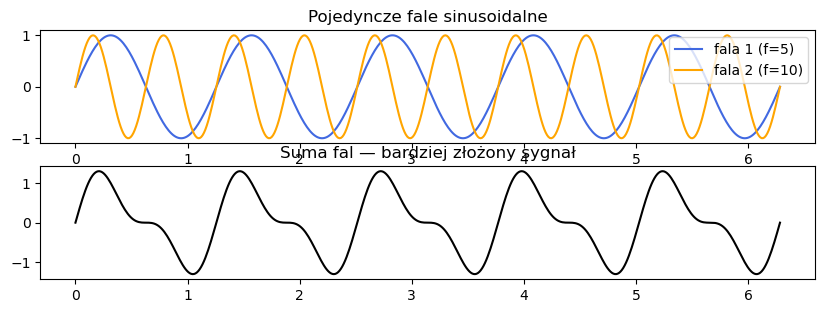

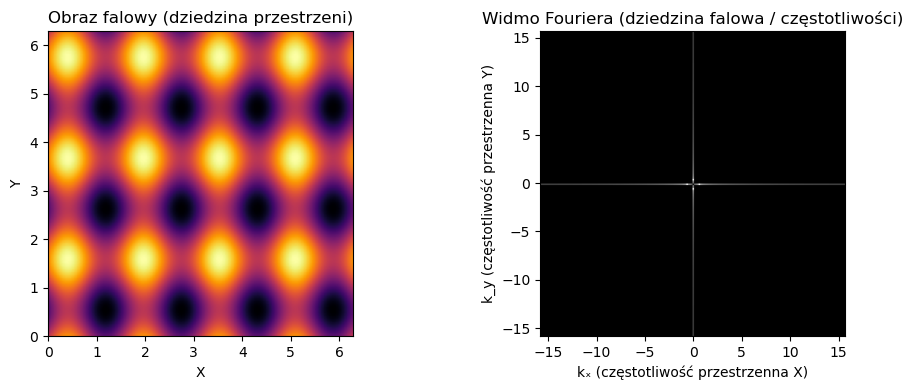

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft2

# --- 1D fale ---
x = np.linspace(0, 2*np.pi, 500)
wave1 = np.sin(5*x)
wave2 = np.sin(10*x)
combined = wave1 + 0.5*wave2

plt.figure(figsize=(10,5))
plt.subplot(3,1,1)
plt.plot(x, wave1, 'royalblue', label='fala 1 (f=5)')
plt.plot(x, wave2, 'orange', label='fala 2 (f=10)')
plt.legend(); plt.title("Pojedyncze fale sinusoidalne")

plt.subplot(3,1,2)
plt.plot(x, combined, 'black')
plt.title("Suma fal — bardziej złożony sygnał")

# --- 2D siatka fal (obraz falowy) ---
X, Y = np.meshgrid(np.linspace(0, 2*np.pi, 200), np.linspace(0, 2*np.pi, 200))
Z = np.sin(4*X) + np.sin(3*Y)



F = fftshift(fft2(Z))
magnitude = np.log(1 + np.abs(F))  # log-scale, lepsza widoczność

kx = np.fft.fftshift(np.fft.fftfreq(Z.shape[1], d=(X[0,1]-X[0,0])))
ky = np.fft.fftshift(np.fft.fftfreq(Z.shape[0], d=(Y[1,0]-Y[0,0])))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(Z, cmap='inferno', extent=(0,2*np.pi,0,2*np.pi))
plt.title("Obraz falowy (dziedzina przestrzeni)")
plt.xlabel("X"); plt.ylabel("Y")

plt.subplot(1,2,2)
plt.imshow(magnitude, cmap='gray', extent=(kx[0],kx[-1],ky[0],ky[-1]))
plt.title("Widmo Fouriera (dziedzina falowa / częstotliwości)")
plt.xlabel("kₓ (częstotliwość przestrzenna X)")
plt.ylabel("k_y (częstotliwość przestrzenna Y)")
plt.tight_layout()
plt.show()

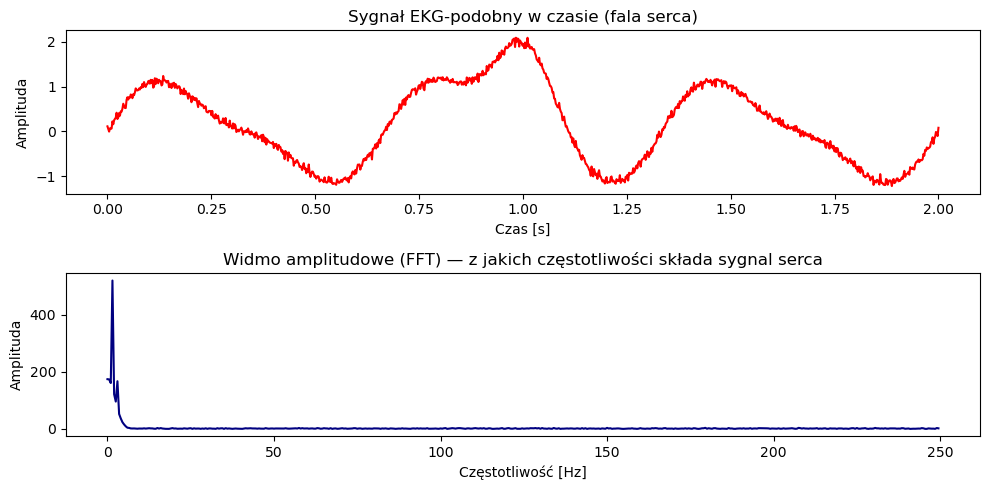

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fs = 500
t = np.linspace(0, 2, 2*fs)
# sygnał EKG-podobny
x = np.sin(2*np.pi*1.5*t) + 0.3*np.sin(2*np.pi*3*t)
x += np.exp(-100*(t-1)**2)*2.0  # impuls QRS
x += 0.05*np.random.randn(len(t))

# FFT
X = np.fft.fft(x)
freq = np.fft.fftfreq(len(x), 1/fs)

# wykres
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t, x, color='red')
plt.title("Sygnał EKG-podobny w czasie (fala serca)")
plt.xlabel("Czas [s]"); plt.ylabel("Amplituda")

plt.subplot(2,1,2)
plt.plot(freq[:len(freq)//2], np.abs(X)[:len(X)//2], color='navy')
plt.title("Widmo amplitudowe (FFT) — z jakich częstotliwości składa sygnal serca️")
plt.xlabel("Częstotliwość [Hz]"); plt.ylabel("Amplituda")
plt.tight_layout()
plt.show()

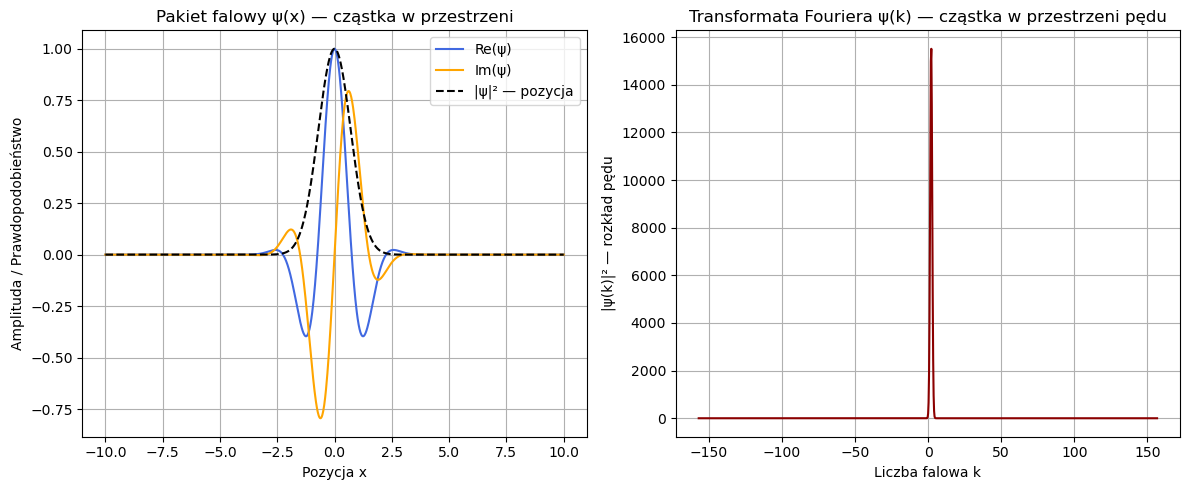

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- pakiet falowy w przestrzeni ---
x = np.linspace(-10, 10, 1000)
k0 = 2*np.pi / 3        # liczba falowa (pęd średni)
sigma = 1.0             # szerokość pakietu Gaussa
psi = np.exp(-x**2/(2*sigma**2)) * np.exp(1j*k0*x)

# --- transformata Fouriera (do przestrzeni pędu) ---
psi_k = np.fft.fftshift(np.fft.fft(psi))
k = np.fft.fftshift(np.fft.fftfreq(len(x), d=(x[1]-x[0])))*2*np.pi

# --- wykresy ---
plt.figure(figsize=(12,5))

# fala w przestrzeni
plt.subplot(1,2,1)
plt.plot(x, np.real(psi), label="Re(ψ)", color='royalblue')
plt.plot(x, np.imag(psi), label="Im(ψ)", color='orange')
plt.plot(x, np.abs(psi)**2, '--', color='black', label="|ψ|² — pozycja")
plt.title("Pakiet falowy ψ(x) — cząstka w przestrzeni")
plt.xlabel("Pozycja x"); plt.ylabel("Amplituda / Prawdopodobieństwo")
plt.legend(); plt.grid(True)

# widmo pędu
plt.subplot(1,2,2)
plt.plot(k, np.abs(psi_k)**2, color='darkred')
plt.title("Transformata Fouriera ψ(k) — cząstka w przestrzeni pędu")
plt.xlabel("Liczba falowa k"); plt.ylabel("|ψ(k)|² — rozkład pędu")
plt.grid(True)

plt.tight_layout()
plt.show()

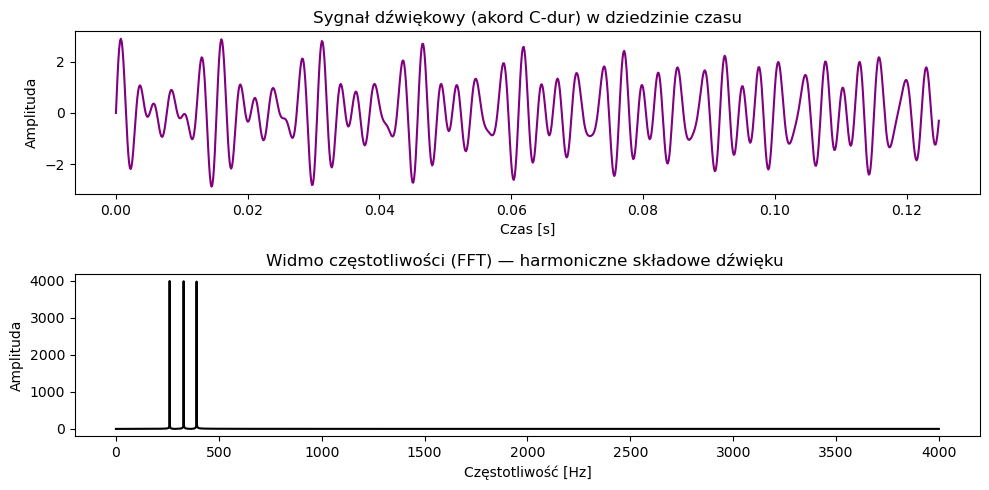

In [15]:
import numpy as np
import matplotlib.pyplot as plt

fs = 8000
t = np.linspace(0, 1, fs)
# akord C-dur: C (261 Hz), E (329 Hz), G (392 Hz)
signal = np.sin(2*np.pi*261*t) + np.sin(2*np.pi*329*t) + np.sin(2*np.pi*392*t)

# FFT
X = np.fft.fft(signal)
freq = np.fft.fftfreq(len(t), 1/fs)

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t[:1000], signal[:1000], color='purple')
plt.title("Sygnał dźwiękowy (akord C-dur) w dziedzinie czasu")
plt.xlabel("Czas [s]"); plt.ylabel("Amplituda")

plt.subplot(2,1,2)
plt.plot(freq[:len(freq)//2], np.abs(X)[:len(X)//2], color='black')
plt.title("Widmo częstotliwości (FFT) — harmoniczne składowe dźwięku ")
plt.xlabel("Częstotliwość [Hz]"); plt.ylabel("Amplituda")
plt.tight_layout()
plt.show()

# ⚙️ Transformata Fouriera

---

## Opis

Transformata Fouriera to jedno z najważniejszych narzędzi matematycznych w analizie sygnałów.
Pozwala przekształcić dowolny sygnał z **dziedziny czasu (lub przestrzeni)**
do **dziedziny częstotliwości** — czyli opisać, *z jakich fal jest zbudowany*.

> Każdy sygnał można rozłożyć na sumę fal sinusoidalnych o różnych częstotliwościach i amplitudach.

---

## Zasada dzialania

Dowolną funkcję $ f(x) $ można zapisać jako kombinację fal o różnych częstotliwościach:

$$
f(x) = \int_{-\infty}^{+\infty} F(k)\, e^{i 2\pi kx}\, dk
$$

gdzie:
- $ e^{i 2\pi kx} $ – fala bazowa o częstotliwości $ k $,
- $ F(k) $ – amplituda tej częstotliwości w sygnale,
- całka – sumuje wszystkie możliwe fale.

---

## Transformata i odwrotna transformata

$$
\boxed{
\begin{aligned}
F(k) &= \int_{-\infty}^{+\infty} f(x)\, e^{-i 2\pi kx}\, dx \\[6pt]
f(x) &= \int_{-\infty}^{+\infty} F(k)\, e^{i 2\pi kx}\, dk
\end{aligned}
}
$$

- **Transformata Fouriera** $F(k)$ – pokazuje, jakie częstotliwości występują w sygnale.
- **Odwrotna transformata** $f(x)$ – pozwala odtworzyć sygnał z jego widma.

---

## Opis geometryczny

Fale zespolone $ e^{i2\pi kx} $ tworzą **pełny i ortogonalny zestaw funkcji bazowych**.
Każda fala reprezentuje pewien „ton” lub „częstotliwość”,
a każda funkcja $ f(x) $ jest *kombinacją wszystkich tych czestotliwosci*.

---


## Zdjecie jako funkcja

Nasz obraz można zapisać jako funkcję dwóch zmiennych — jego jasności w każdym punkcie:

$$
f(x, y) = \text{jasność piksela w punkcie } (x, y)
$$

W obrazie w odcieniach szarości \( f(x, y) \) przyjmuje wartości np. od **0 (czarny)** do **255 (biały)**,
a dla obrazów kolorowych mamy trzy funkcje:
$$
f_R(x, y), f_G(x, y), f_B(x, y)
$$
Każdy piksel jest więc **próbką funkcji** opisującej rozkład intensywności w przestrzeni.

---

## Transformata Fouriera 2D

W przypadku obrazu (funkcji dwuwymiarowej):

$$
F(u, v) = \int\!\!\int f(x, y)\, e^{-j2\pi(ux + vy)}\, dx\, dy
$$

gdzie:
- $ f(x,y) $ – obraz w dziedzinie przestrzennej,
- $ F(u,v) $ – jego reprezentacja w dziedzinie częstotliwości,
- $ (u,v) $ – częstotliwości przestrzenne.

Wartość $ F(u,v) $ pokazuje, jak szybko zmieniają się jasności w różnych kierunkach obrazu.

---

## Zastosowania w obrazowaniu (CT, MRI)

W tomografii komputerowej (CT) każda **projekcja 2D** odpowiada przekrojowi widma Fouriera obiektu.
Zgodnie z **Twierdzeniem Przekrojowym (Fourier Slice Theorem)**,
można zrekonstruować cały obraz z jego widma, wykonując **odwrotną transformację Fouriera**.

Dzięki temu:
- tomograf komputerowy (CT),
- rezonans magnetyczny (MRI),

mogą tworzyć obraz wnętrza obiektu na podstawie fal (częstotliwości) zarejestrowanych na zewnątrz.

---

## Zastosowania w uczeniu maszynowym (ML)

Transformata Fouriera i jej wersje dyskretne (FFT, DCT)
są powszechnie stosowane w analizie danych i modelach głębokiego uczenia:

| Dziedzina | Przykład zastosowania |
|------------|-----------------------|
| 🎧 **Audio / Mowa** | Ekstrakcja cech (spektrogramy, MFCC), klasyfikacja muzyki i mowy |
| 💓 **Bio-sygnały** | EEG, EKG – analiza rytmów, filtracja zakłóceń |
| 📷 **Obrazy (CNN)** | Filtrowanie, denoising, rekonstrukcja w dziedzinie widma |
| 🧠 **Fourier Neural Operators (FNO)** | Sieci uczące równania PDE w dziedzinie częstotliwości |
| ⚙️ **FFT Convolution Layers** | Przyspieszone konwolucje z wykorzystaniem FFT |
| 🌐 **Vision Transformers (ViT)** | Fourier Features – reprezentacja pozycyjna w domenie falowej |

---

## W skrócie

- Transformata Fouriera:
  ➜ rozkłada dane na **częstotliwości (analiza widma)**.
- Odwrotna transformata:
  ➜ rekonstruuje dane z widma (**powrót do przestrzeni czasu / obrazu**).
- W ML i przetwarzaniu danych:
  ➜ służy do **filtracji, redukcji szumów, kompresji i analizy cech częstotliwościowych**.

---

## Podsumowanie

Transformata Fouriera to **matematyczny język fal** —
pozwala opisać każdy sygnał, obraz lub dane przestrzenno-czasowe
w sposób, w jaki rzeczywiście funkcjonuje fizyczny świat:
poprzez jego częstotliwości.

$$
\text{czas / przestrzeń} \;\;\xleftrightarrow{\text{Fourier}}\;\; \text{częstotliwość / widmo}
$$


## ⚡ FFT — Szybka Transformata Fouriera

Transformata Fouriera w swojej klasycznej, całkowej postaci jest ciągła,
ale w praktyce dane (sygnały, obrazy) są **dyskretne i skończone**.
Dlatego stosujemy **Dyskretną Transformatę Fouriera (DFT)**,
a jej szybka wersja — **Fast Fourier Transform (FFT)** —
jest jednym z najważniejszych algorytmów numerycznych w historii informatyki.

---

### 🧮 Definicja DFT

Dla sygnału o $N$ próbkach $x_0, x_1, \dots, x_{N-1}$
dyskretna transformata Fouriera (DFT) ma postać:

$$
X_k = \sum_{n=0}^{N-1} x_n\, e^{-i 2\pi kn / N},
\quad k = 0, 1, \dots, N-1
$$

a odwrotna transformata:

$$
x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k\, e^{i 2\pi kn / N}
$$

---

### 🚀 Na czym polega FFT

Bezpośrednie obliczenie DFT wymaga $\mathcal{O}(N^2)$ operacji.
Algorytm FFT (Fast Fourier Transform) — opracowany przez Cooleya i Tukeya (1965) —
redukuje złożoność do $\mathcal{O}(N \log N)$,
co umożliwia analizę bardzo dużych sygnałów i obrazów w czasie rzeczywistym.

FFT działa poprzez **rekurencyjne dzielenie sygnału na części parzyste i nieparzyste**,
a następnie łączenie wyników z wykorzystaniem symetrii zespolonych wykładników (tzw. „twiddle factors”).

---

### 🧠 Intuicja

FFT to nie nowa transformacja, lecz **optymalny sposób obliczania DFT**.
Matematycznie daje ten sam wynik, ale tysiące razy szybciej.

To dzięki FFT możliwe są m.in.:
- wizualizacje widma audio w czasie rzeczywistym,
- przetwarzanie sygnałów EKG/EEG w medycynie,
- rekonstrukcja obrazów w tomografii (CT, MRI),
- kompresja JPEG / MP3,
- przyspieszone konwolucje w sieciach neuronowych (FFT Conv).



⏱️  Czas DFT (manualnie): 0.1239 s
⚡ Czas FFT (numpy):      0.000054 s
🔍 Maksymalna różnica wyników: 1.05e-11


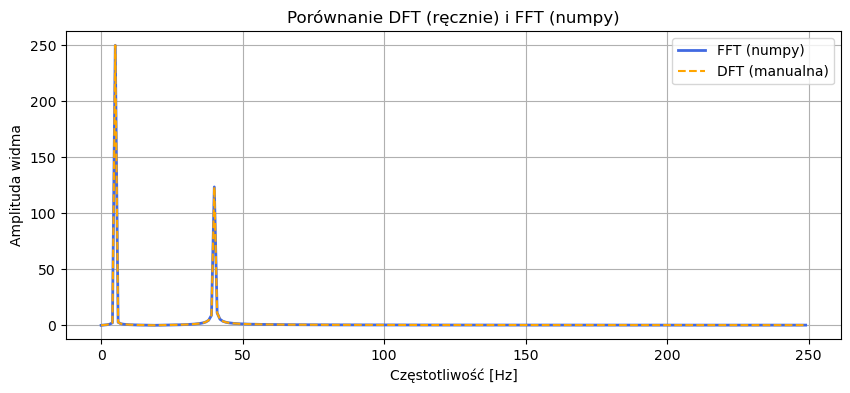

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Parametry sygnału ---
fs = 500                # częstotliwość próbkowania [Hz]
N = 500                 # liczba próbek
t = np.linspace(0, 1, N)
x = np.sin(2*np.pi*5*t) + 0.5*np.sin(2*np.pi*40*t)

# --- 1️⃣ Manualna implementacja DFT ---
def DFT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X

start_dft = time.time()
X_dft = DFT(x)
end_dft = time.time()

# --- 2️⃣ FFT (Fast Fourier Transform) ---
start_fft = time.time()
X_fft = np.fft.fft(x)
end_fft = time.time()

# --- 3️⃣ Porównanie wyników ---
diff = np.max(np.abs(X_dft - X_fft))  # maksymalna różnica numeryczna

print(f"⏱️  Czas DFT (manualnie): {end_dft - start_dft:.4f} s")
print(f"⚡ Czas FFT (numpy):      {end_fft - start_fft:.6f} s")
print(f"🔍 Maksymalna różnica wyników: {diff:.2e}")

# --- 4️⃣ Wizualizacja widma ---
freq = np.fft.fftfreq(N, 1/fs)

plt.figure(figsize=(10,4))
plt.plot(freq[:N//2], np.abs(X_fft)[:N//2], label="FFT (numpy)", color='royalblue', lw=2)
plt.plot(freq[:N//2], np.abs(X_dft)[:N//2], '--', label="DFT (manualna)", color='orange')
plt.title("Porównanie DFT (ręcznie) i FFT (numpy)")
plt.xlabel("Częstotliwość [Hz]")
plt.ylabel("Amplituda widma")
plt.legend()
plt.grid(True)
plt.show()

# Filtracja Sygnalu Audio za pomoca FFT

✅ Zapisano pliki: sos_clean.wav, sos_noisy.wav, sos_filtered.wav


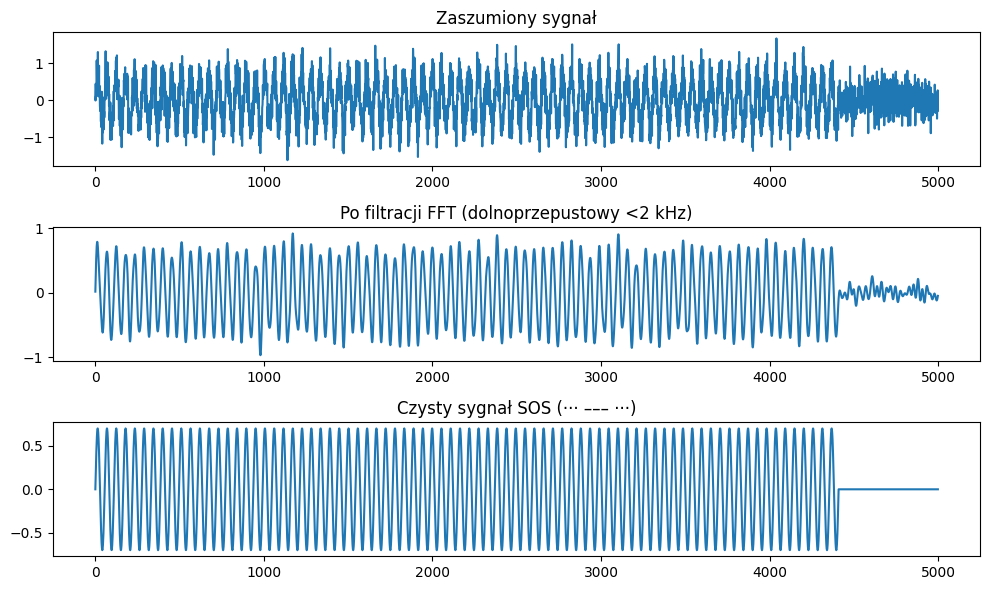

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from numpy.fft import fft, ifft, fftfreq
from IPython.display import Audio, display, HTML

# ======================================================
# 1️⃣ Parametry sygnału
# ======================================================
fs = 44100         # częstotliwość próbkowania [Hz]
freq = 800         # częstotliwość tonu Morse’a [Hz]
dot = 0.1          # czas "kropki" [s]
dash = 3 * dot     # czas "kreski"
gap = dot          # odstęp między elementami w literze
pause = 3 * dot    # odstęp między literami

# ======================================================
# 2️⃣ Funkcja do generowania elementów Morse’a
# ======================================================
def tone(duration):
    t = np.linspace(0, duration, int(fs*duration), endpoint=False)
    return np.sin(2*np.pi*freq*t)

def silence(duration):
    return np.zeros(int(fs*duration))

# ======================================================
# 3️⃣ Sygnał SOS = ... --- ...
# ======================================================
signal = np.concatenate([
    tone(dot), silence(gap), tone(dot), silence(gap), tone(dot), silence(pause),  # S
    tone(dash), silence(gap), tone(dash), silence(gap), tone(dash), silence(pause), # O
    tone(dot), silence(gap), tone(dot), silence(gap), tone(dot)  # S
])

# normalizacja amplitudy
signal_clean = 0.7 * signal

# ======================================================
# 4️⃣ Dodanie szumu
# ======================================================
noise = 0.3 * np.random.normal(0, 1, len(signal_clean))
signal_noisy = signal_clean + noise

# ======================================================
# 5️⃣ Filtracja FFT – usunięcie wysokich częstotliwości
# ======================================================
yf = fft(signal_noisy)
xf = fftfreq(len(signal_noisy), 1/fs)

cutoff = 2000  # zostaw tylko do 2 kHz
mask = np.abs(xf) < cutoff
yf_filtered = yf * mask
signal_filtered = np.real(ifft(yf_filtered))

# ======================================================
# 6️⃣ Zapis do plików
# ======================================================
write("audios/sos_clean.wav", fs, (signal_clean * 32767).astype(np.int16))
write("audios/sos_noisy.wav", fs, (signal_noisy * 32767).astype(np.int16))
write("audios/sos_filtered.wav", fs, (signal_filtered * 32767).astype(np.int16))

print("✅ Zapisano pliki: sos_clean.wav, sos_noisy.wav, sos_filtered.wav")

# ======================================================
# 7️⃣ Wizualizacja
# ======================================================
plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
plt.plot(signal_noisy[:5000])
plt.title("Zaszumiony sygnał")

plt.subplot(3,1,2)
plt.plot(signal_filtered[:5000])
plt.title("Po filtracji FFT (dolnoprzepustowy <2 kHz)")

plt.subplot(3,1,3)
plt.plot(signal_clean[:5000])
plt.title("Czysty sygnał SOS (··· ––– ···)")

plt.tight_layout()
plt.show()




display(HTML("<h3>🌫️ SOS — zaszumiony sygnał</h3>"))
display(Audio("audios/sos_noisy.wav"))

display(HTML("<h3>✨ SOS — po filtracji FFT</h3>"))
display(Audio("audios/sos_filtered.wav"))


display(HTML("<h3>🔊 SOS — czysty sygnał</h3>"))
display(Audio("audios/sos_clean.wav"))



## Czym jest tomografia komputerowa (CT)?


<img src="images/Tomograf_wmw_sggw.jpg" width="100%">

Tomografia komputerowa to technika obrazowania medycznego służąca do uzyskiwania szczegółowych obrazów wnętrza ciała. Skanery TK wykorzystują obracającą się lampę rentgenowską i rząd detektorów umieszczonych w gantrze do pomiaru osłabienia promieniowania rentgenowskiego przez różne tkanki wewnątrz ciała. Wiele pomiarów promieniowania rentgenowskiego wykonanych pod różnymi kątami jest następnie przetwarzanych w komputerze przy użyciu algorytmów rekonstrukcji tomograficznej w celu uzyskania tomograficznych (przekrojowych) obrazów (wirtualnych „wycinków”) ciała. Badania TK mogą być stosowane u pacjentów z metalowymi implantami lub rozrusznikami serca, dla których rezonans magnetyczny (MRI) jest przeciwwskazany.
<br><br>
*Zbiór przekrojów 2D ludzkiego mózgu, uzyskany za pomocą tomografii komputerowej.*
<br>
<img src="images/Slices.png" width="100%">

<br><br>

W przeciwieństwie do klasycznego zdjęcia rentgenowskiego, które nakłada na siebie wszystkie
warstwy ciała, tomografia komputerowa umożliwia uzyskanie **obrazów przekrojowych (ang. slices)** tzw. tomogramów,
czyli oddzielnych warstw wnętrza pacjenta — bez fizycznego rozcinania ciała. ( na szczescie ). <br>
Następnie obrazy są nakładane tworząc trójwymiarowy wokselowy tomogram obiektu.


<img src="gifs/ct_gen_fourth_gen.gif" width="100%">



---
## Forma danych i teoretyczna rekonstrukcja obrazu
Podczas badania, lampa rentgenowska obraca się wokół pacjenta, a detektory mierzą intensywność promieniowania rentgenowskiego po jego przejściu przez ciało pod różnymi kątami. <br>
Jeżeli $I_0$ oznaczymy jako natężenie promieniowania wyemitowanego przez lampę a $I$ jako natężenie promieniowania wychwyconego przez detektor to te dwie wielkości można opisać zależnością Beera-Lamberta:
$$
I = I_0e^{-\int_L \mu(x, y)\, dl}
$$
gdzie $\mu (x, y)$ to "gęstość optyczna" w punkcie $(x,y)$ a $L$ to ścieżka promieniowania przez ciało. <br><br>
Zbiór całek $\int \mu (x) dx$ jest odpowiedni dwuwymiarowej tzw. transformacie Radona czyli funkcji w przestrzeni lini $L \subset R^2$, która dla każdej pary ($\theta$ - kąt lini, $r$ - odległość lini od początku układu współrzędnych) przyporządkowuje całkę po tej lini na płaszczyźnie $\mu (x, y)$:
$$
Rf(\theta , r) = \int_{-\infty}^{\infty} \mu (x(s), y(s))ds = \int_{-\infty}^{\infty} \mu ((s\sin \theta + r\cos \theta), (-s\cos \theta + r\sin \theta))ds
$$
Takie dane tworzą tzw. sinogram: <br><br>
<img src="images/sinogram.jpeg" width="100%">
<br><br>

---
Aby otrzymać 2d tomogram musimy znaleźć transformację odwrotną:
$$
\mu (x, y) = R^{-1}\{Rf(\theta, r)\}
$$
---
<img src="images/Tomographic_fig1.png"  width="100%">


---
### Algorytm projekcji wstecznej (Backprojection).

Algorytm back projection polega na powrotnym nałożeniu na siebie wszystkich projekcji, po wcześniejszym ich przeskalowaniu:
$$
    f_{bp}(x, y) = \int_0^{\pi}Rf(\theta, x\cos\theta + y\sin\theta)d\theta
$$
Tutaj prosty skrypt (credits: chatgpt), który wizualizuje algorytm projekcji wstecznej (parametry są modyfikowalne):


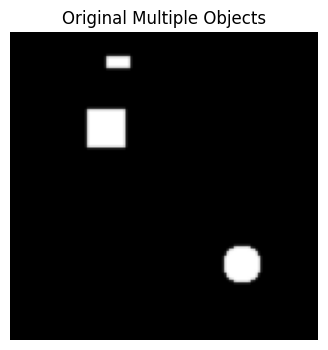
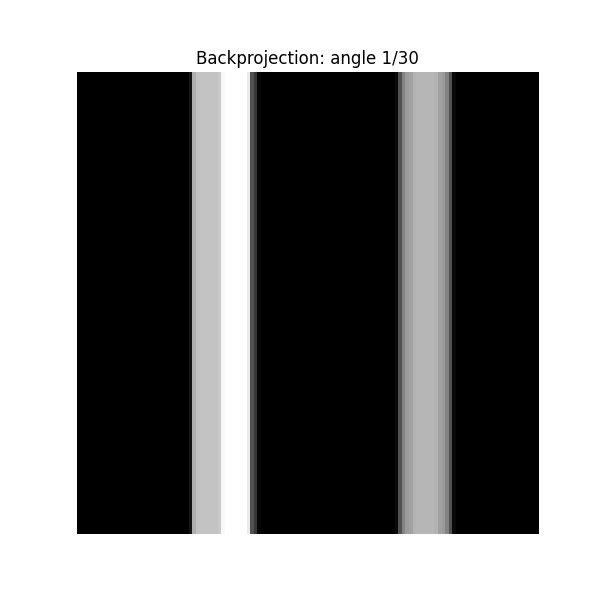
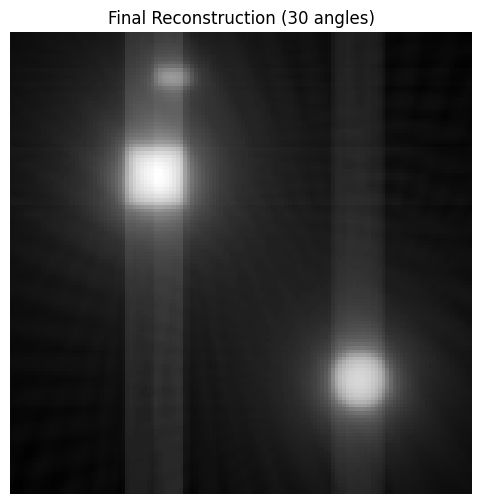

In [2]:

# -----------------------------
# Parameters
# -----------------------------
image_size = 128
num_angles = 30
num_rays = 128
save_gif = "backprojection_multiple_objects.gif"

# -----------------------------
# Create multiple objects
# -----------------------------
object_img = np.zeros((image_size, image_size))

# Object 1: square
object_img[image_size//4:3*image_size//8, image_size//4:3*image_size//8] = 1

# Object 2: circle
cx, cy = int(3*image_size/4), int(3*image_size/4)
r = 8
for i in range(image_size):
    for j in range(image_size):
        if (i-cy)**2 + (j-cx)**2 < r**2:
            object_img[i,j] = 1

# Object 3: small rectangle
object_img[10:15, 40:50] = 1

# Optional: smooth edges
object_img = gaussian_filter(object_img, sigma=0.5)

# -----------------------------
# Compute projections
# -----------------------------
angles = np.linspace(0, 180, num_angles, endpoint=False)
projections = np.zeros((num_angles, num_rays))

for i, theta in enumerate(angles):
    rotated = rotate(object_img, theta, reshape=False, order=1)
    projection = np.sum(rotated, axis=0)
    projections[i] = np.interp(np.linspace(0, image_size-1, num_rays),
                               np.arange(image_size), projection)

# -----------------------------
# Backprojection animation (centered)
# -----------------------------
reconstruction = np.zeros((image_size, image_size))

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(reconstruction, cmap='gray', vmin=0, vmax=1)
ax.axis('off')
ax.set_title("Backprojection in Progress")

# Center coordinates
x = np.arange(image_size) - image_size/2
y = np.arange(image_size) - image_size/2
X, Y = np.meshgrid(x, y)

def update(frame):
    global reconstruction
    theta = angles[frame]
    t = X * np.cos(np.deg2rad(theta)) + Y * np.sin(np.deg2rad(theta))
    t_scaled = (t + image_size/2) * (num_rays / image_size)
    t_scaled = np.clip(t_scaled, 0, num_rays-1)
    reconstruction += np.interp(t_scaled.flatten(), np.arange(num_rays), projections[frame]).reshape(image_size, image_size)
    im.set_data(reconstruction / reconstruction.max())
    ax.set_title(f"Backprojection: angle {frame+1}/{num_angles}")
    return [im]

ani = FuncAnimation(fig, update, frames=num_angles, blit=True)
ani.save(save_gif, writer=PillowWriter(fps=5))
plt.close(fig)

import base64

# Convert matplotlib image to base64
import matplotlib.pyplot as plt
import io

def plt_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_bytes = buf.read()
    base64_str = base64.b64encode(img_bytes).decode('utf-8')
    plt.close(fig)
    return base64_str

# 1. Original object image
fig1 = plt.figure(figsize=(4,4))
plt.title("Original Multiple Objects")
plt.imshow(object_img, cmap='gray')
plt.axis('off')
img1_base64 = plt_to_base64(fig1)

# 2. Final reconstruction
fig2 = plt.figure(figsize=(6,6))
plt.title(f"Final Reconstruction ({num_angles} angles)")
plt.imshow(reconstruction / reconstruction.max(), cmap='gray')
plt.axis('off')
img2_base64 = plt_to_base64(fig2)

# 3. GIF file (convert to base64)
with open(save_gif, "rb") as f:
    gif_base64 = base64.b64encode(f.read()).decode('utf-8')

# Display all horizontally
html_str = f"""
<div style="display:flex; align-items:center; gap:20px;">
    <div>
        <img src="data:image/png;base64,{img1_base64}" width="400"><br>
        <p style="text-align:center;">Original Multiple Objects</p>
    </div>
    <div>
        <img src="data:image/gif;base64,{gif_base64}" width="400"><br>
        <p style="text-align:center;">GIF Animation</p>
    </div>
    <div>
        <img src="data:image/png;base64,{img2_base64}" width="400"><br>
        <p style="text-align:center;">Final Reconstruction</p>
    </div>
</div>
"""

display(HTML(html_str))

---
## Problemy algorytmu backprojection

Niestety naiwne backprojection nie umożliwia rekonstrukcji obrazu wysokiej jakości. Aby to zrozumieć trzeba zrozumieć czym jest transformacja Fouriera (tu odnośnik do drugiego notebooka?).
<br>
<br>

Obrazy są rozmyte, ponieważ po rekonstrukcji $f_{bp}$ niższe częstotliwości są nadreprezentowane w widmie naszego tomogramu:
$$
 \mathcal{F_2}\{f_{bp}\}(\Omega_1, \Omega_2) = \frac{2\pi}{|\omega|}F(\Omega_1, \Omega_2)
$$
gdzie:<br>
$\mathcal{F_2}$ - 2d operator transformacji Fouriera.<br>
$F$ - 2d transformata Fouriera oryginalnej funkcji $\mu$ <br>
$\omega = \sqrt{\Omega_1^2 + \Omega_2^2}$<br><br>

Jak widać, amplituda częstotliwości niskich (bliskie zeru) jest wzmacniana a wysokich - wygłuszana (czynnik $\frac{1}{|\omega|}$). <br><br>

Powyższe wnioski prowadzą nas do algorytmu filtered backprojection ale wcześniej musimy zrozumieć fourier slice theorem.

## Fourier slice theorem

Załóżmy, że mamy 2d funkcję $f(x,y)$ i: <br>
$\mathcal{F_1}$ oraz $\mathcal{F_2}$ - odpowiednio 1d oraz 2d operator transformacji fouriera. <br>
$P_1$ - operator projekcji z przestrzeni 2d na linię (np transformacja radona). <br>
$S_1$ - operator przekroju (slice operator). Wycina tą samą linię z funkcji 2d.<br>

Fourier slice theorem mówi że:
$$
        F_1P_1 = S_1F_2
$$
Czyli transformata Fouriera projekcji funkcji dwuwymiarowej na prostą odpowiada przekrojowi dwuwymiarowej transformaty Fouriera tej funkcji wzdłuż tej samej prostej.<br>

_Dowód:_ <br>
weźmy $f(x,y)$ i jej projekcję $p(x)$ na oś x daną wzorem:
$$
        p(x) = \int_{-\infty}^{\infty}f(x,y)dy
$$
Transformata funkcji $f$ to:
$$
F(\Omega_x, \Omega_y) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}f(x,y)e^{-2\pi i(x\Omega_x + y\Omega_y)}dxdy
$$
Nasz przekrój $s(\Omega_x)$ to:
$$
s(\Omega_x) = F(\Omega_x, 0) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}f(x,y)e^{-2\pi ix\Omega_x}dxdy \\
= \int_{-\infty}^{\infty}\left[\int_{-\infty}^{\infty}f(x,y)dy\right]e^{-2\pi ix\Omega_x}dx \\
= \int_{-\infty}^{\infty}p(x)e^{-2\pi ix\Omega_x}dx
$$
Co jest równe transformacie $\mathcal{F_1}\{p\}$. <br><br><br>


---

## Filtered backprojection

W tym rozdziale wyprowadzimy wzór na algorytm filtered backprojection (filtrowana projekcja wsteczna?). <br>
Przypomnijmy: <br>
transformacja Radona: &emsp;&emsp;&emsp; $Rf(\phi, r) = \mathcal{R}\{\mu (x, y)\}$ <br>
1d transformacja Fouriera: &emsp; $\mathcal{F_1}\{Rf(\phi, r)\} = P(\phi, \omega)$ <br>
2d transformacja Fouriera: &emsp; $\mathcal{F_2}\{\mu(x, y)\} = F(\Omega_1, \Omega_2)$ <br><br>

Przy naszych oznaczeniach możemy sformułować Fourier Slice Theorem jako: <br><br>
$$
\mathcal{F_1}\{Rf(\phi = \phi', r)\} = \mathcal{F_2}\{\mu(x, y)\}|_{\phi = \phi'}
$$<br><br>

chcemy znaleźć $\mu (x, y)$, możemy zapisać to po prostu: <br><br>
$$
\mu (x, y) = \mathcal{F_2^{-1}}\{\mathcal{F_2}\{\mu (x, y)\}\} = \mathcal{F_2^{-1}}\{F(\Omega_1, \Omega_2)\}
$$ <br><br>

Rozwijamy odwrotną transformację Fouriera: <br><br>

$$
\mu (x, y) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}F(\Omega_1, \Omega_2)e^{2\pi i(\Omega_1 x + \Omega_2 y)} d\Omega_1 d\Omega_2
$$ <br><br>

zmieniamy współrzędne $\Omega_1$ i $\Omega_2$ na biegunowe $\omega$, $\phi$: <br><br>

$\omega = \sqrt{\Omega_1^2 + \Omega_2^2}$<br>
$tg \phi = \frac{\Omega_1}{\Omega_2}$<br><br>

żeby zmienić współrzędne przy całkowaniu trzeba policzyć wyznacznik jakobiana przejścia:<br><br>
$J = \begin{pmatrix}
\frac{\partial \Omega_1}{\partial \omega} & \frac{\partial \Omega_1}{\partial \phi} \\[4pt]
\frac{\partial \Omega_2}{\partial \omega} & \frac{\partial \Omega_2}{\partial \phi}
\end{pmatrix} = \begin{pmatrix}
\cos \phi & -\omega \cos \phi \\[4pt]
\sin \phi & \omega \cos \phi
\end{pmatrix} = \omega (\cos^2\phi + sin^2\phi) = \omega$ <br><br>

teraz: <br><br>

$$
\mu (x, y) = \int_{0}^{\pi}\int_{-\infty}^{\infty}|\omega|F(\omega \cos \phi, \omega \sin \phi)e^{2\pi i \omega(x \cos \phi + y \sin \phi)} d\omega d\phi
$$ <br><br>

Korzystając z Fourier slice theorem możemy podstawić $F(\omega \cos \phi, \omega \sin \phi) = P(\phi, \omega)$: <br><br>

$$
\mu (x, y) = \int_{0}^{\pi}\int_{-\infty}^{\infty}|\omega|P(\phi, \omega)e^{2\pi i \omega(x \cos \phi + y \sin \phi)} d\omega d\phi
$$ <br><br>

Możemy skrócić powyższą formułę: <br><br>

$$
\mu (x, y) = \int_{0}^{\pi} \mathcal{F_1^{-1}}\{P(\phi, \omega) * |\omega|\} d\phi
$$

## Algorytm filtered backprojection (intuicja)

Dzięki powyższemu równaniu możemy sformułować **algorytm filtrowanej projekcji wstecznej (Filtered Backprojection)** następująco:

---

**Dane:** transformata Radona (scałkowane linie):  
$R f(\phi, r)$

**Algorytm:**

1. Dla każdej linii $ Rf(\phi, r) $ oblicz **jednowymiarową transformatę Fouriera**:
   $
   P(\phi, \omega) = \mathcal{F}_1\{ Rf(\phi, r) \}.
   $

2. Wymnóż otrzymaną transformatę przez filtr $|\omega|$:
   $
   P_f(\phi, \omega) = |\omega| \cdot P(\phi, \omega).
 $

3. Oblicz **odwrotną transformatę Fouriera**:
   $
   \tilde{R}f(\phi, r) = \mathcal{F}_1^{-1}\{ P_f(\phi, \omega) \}.
   $

4. Wykonaj **projekcję wsteczną** (scałkuj po półkolu):
   $
   f(x, y) = \int_{0}^{\pi} \tilde{R}f\big(\phi,\, x\cos\phi + y\sin\phi\big)\, d\phi.
   $
   <br><br>

<div float="left">
    <img src="images/scanning.gif">
    <img src="images/backprojection_vis.gif">
    <img src="images/filteredbackprojection_vis.gif">
</div>

Jeżeli dysponowalibyśmy nieskończoną liczbą projekcji, algorytm filtered backprojection umożliwiłby idealną rekonstrukcję obrazu. Niestety, z powodu ich skończonej liczby, rekonstruowany obraz zawiera artefakty.

## Zadanie (nieobowiązkowe)
a) Wyznacz całkę projekcji $\int_l \mu (x) dl$ ze wzoru Beera-Lamberta. Następnie napisz funkcję, która liczy jej wartość mając dane natężenie początkowe $I_0$ oraz końcowe $I$. <br>

In [10]:
import numpy as np
def total_attenuation(I0: np.ndarray, I: np.ndarray) -> np.ndarray:
    #Twój kod
    return -np.log(I / I0)
    return np.zeros_like(I0)


I0 = np.array([133213, 5869345, 34894304])
I = np.array([23456, 123456, 2345675])

attenuation = [1.73682303, 3.8616135,  2.6997504]

assert np.allclose(total_attenuation(I0, I), attenuation)

[1.73682303, 3.8616135, 2.6997504]


b) Teoretycznie transformacja Fouriera jest całką niewłaściwą (i to nie zwykłą całką Riemanna, lecz całką Lebesgue'a). W praktyce zwykle funkcja f jest na tyle skomplikowana, że analityczne wyznaczenie wartości tej całki staje się niemożliwe. W większości zastosowań (w tym również w tomografii komputerowej) wykorzystuje się dyskretną transformację Fouriera, która operuje na dyskretnych sekwencjach danych (co ciekawe istnieje bardzo szybki algorytm, który pozwala wyznaczyć jej wartość zwany Fast Fourier Transform).<br><br>
Napisz dwie funkcje: <br> 
- Pierwsza liczy dyskretną transformację Fouriera dla sekwencji $x_n$. Wynikiem powinna być sekwencja $X_k$. <br>
- Druga liczy jej odwrotność, czyli dla sekwencji $X_k$ wynikiem jest sekwencja $x_n$. <br><br>
Informacje o dyskretnej transformacji fouriera można znaleźć np.:https://en.wikipedia.org/wiki/Discrete_Fourier_transform

In [19]:
import numpy as np
def DFT(x: np.ndarray) -> np.ndarray:
    #Twój kod
    
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-2j * np.pi * k * n / N)
    return W @ x

def IDFT(X: np.ndarray) -> np.ndarray:
    #Twój kod
  
    N = X.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    W_inv = np.exp(2j * np.pi * k * n / N)
    return (W_inv @ X) / N




x = np.sin(np.linspace(0, 2 * np.pi, 10, dtype=np.complex128))
X = np.array([8.81375476e-17+0.00000000e+00j, 1.42837121e+00-4.39607454e+00j, -4.85917548e-01+6.68808128e-01j, -3.91335730e-01+2.84322051e-01j,
     -3.69132810e-01+1.19938521e-01j, -3.63970234e-01-8.08130563e-16j, -3.69132810e-01-1.19938521e-01j, -3.91335730e-01-2.84322051e-01j,
     -4.85917548e-01-6.68808128e-01j, 1.42837121e+00+4.39607454e+00j])

assert np.allclose(X, DFT(x))
assert np.allclose(IDFT(X), x)



---

## Volume Fourier Transform – przejście do 3D

W tomografii komputerowej celem jest odtworzenie **trójwymiarowego rozkładu osłabienia promieniowania**
wewnątrz obiektu, czyli funkcji $\mu(x, y, z)$.

Aby opisać takie dane w dziedzinie częstotliwości, stosuje się **trójwymiarową transformatę Fouriera** (*Volume Fourier Transform*), zdefiniowaną jako:

$$
F(u, v, w) = \iiint f(x, y, z) \, e^{-j2\pi(ux + vy + wz)} \, dx \, dy \, dz
$$

gdzie:
- $f(x,y,z)$ — funkcja reprezentująca wnętrze obiektu (np. gęstość tkanek),
- $F(u,v,w)$ — jej reprezentacja w dziedzinie częstotliwości,
- $(u,v,w)$ — częstotliwości przestrzenne w trzech wymiarach.

---

### 🧩 Intuicja

Każda **projekcja 2D** (obraz CT pod określonym kątem) odpowiada **płaszczyźnie** w przestrzeni częstotliwości $(u,v,w)$.
Zbierając wiele projekcji pod różnymi kątami, wypełniamy tę przestrzeń i możemy odtworzyć pełną strukturę 3D poprzez **odwrotną transformację Fouriera**.

---

### 💡 Znaczenie w uczeniu maszynowym

- Modele oparte na **3D CNN** lub **U-Net 3D** w zadaniach medycznych uczą się działać w przestrzeni, która odpowiada takiej reprezentacji objętościowej.
- W nowoczesnych podejściach (np. *NeRF*, *Fourier Feature Mapping*) sygnały 3D reprezentuje się również w przestrzeni częstotliwości, aby lepiej modelować zależności przestrzenne.
- W **DL-CT** (deep learning computed tomography) sieć może nauczyć się bezpośrednio odwrotnego odwzorowania z płaszczyzn projekcji do przestrzeni 3D, omijając jawne obliczanie transformacji Fouriera.

---

📘 **W skrócie:**
Transformata Fouriera w 3D (Volume Fourier Transform) opisuje, jak rozkładają się częstotliwości w całej objętości —
i stanowi podstawę matematyczną rekonstrukcji trójwymiarowych struktur w tomografii komputerowej.


## Struktura 3D rekonstruowana z wielu 2D projekcji – transformacja Radona i algorytmy rekonstrukcji odwrotnej

Tomografia komputerowa pozwala odtworzyć **trójwymiarową strukturę wnętrza obiektu** na podstawie wielu
**dwuwymiarowych projekcji (obrazów RTG)** uzyskanych pod różnymi kątami.

Każda taka projekcja rejestruje całkę z funkcji osłabienia $\mu(x, y, z)$ wzdłuż promienia przechodzącego przez obiekt.
Z matematycznego punktu widzenia jest to **transformacja Radona**.

---

### 🧩 Transformacja Radona

Transformacja Radona dla obrazu 2D $f(x,y)$ jest zdefiniowana jako:

$$
p_\theta(s) = \int f(x, y)\,\delta(x\cos\theta + y\sin\theta - s)\,dx\,dy
$$

- $p_\theta(s)$ — projekcja (pomiar CT) pod kątem $\theta$,
- $\delta(\cdot)$ — funkcja Diraca, która „wybiera” punkty leżące na linii projekcji,
- $s$ — pozycja detektora dla danej projekcji.

Zestaw wszystkich projekcji dla różnych kątów $\theta$ tworzy **sinogram** — reprezentację wszystkich danych pomiarowych CT.

---

### 🔄 Rekonstrukcja odwrotna (Inverse Radon Transform)

Aby odzyskać oryginalny obraz $f(x, y)$ (lub strukturę 3D $\mu(x, y, z)$), wykonuje się **odwrotną transformację Radona**.
Najczęściej stosowany algorytm to **Filtered Backprojection (FBP)**:

$$
f(x, y) = \int_0^{\pi} \mathcal{F}^{-1}\{|\omega| P_\theta(\omega)\}\big(x\cos\theta + y\sin\theta\big)\,d\theta
$$

czyli:
1. każda projekcja $p_\theta(s)$ jest filtrowana w dziedzinie Fouriera przez $|\omega|$,
2. następnie „rozsuwana” (backprojection) po wszystkich kątach, tworząc pełen obraz.

---

### 🧠 Intuicja

- Każda **projekcja 2D** wnosi część informacji o wnętrzu obiektu wzdłuż konkretnego kierunku.
- Sumując projekcje z wielu kątów, otrzymujemy kompletny opis przestrzeni — czyli **rekonstrukcję 3D**.
- W praktyce komputer wykonuje setki lub tysiące takich operacji, by uzyskać objętość $f(x, y, z)$.

---

### 💡 Związek z uczeniem głębokim

Nowoczesne modele (np. *FBPConvNet*, *Learned Primal-Dual*, *Neural Radon Inversion*) uczą się **aproksymować transformację odwrotną Radona**,
zastępując klasyczne filtry i całki funkcjami uczonymi przez sieć neuronową.

Dzięki temu można rekonstruować obrazy o wysokiej jakości nawet z **niepełnych danych** (np. z mniejszej liczby projekcji, mniejszą dawką promieniowania).

---

📘 **W skrócie:**
Struktura 3D wnętrza obiektu jest odtwarzana z wielu 2D projekcji dzięki transformacji Radona i algorytmom rekonstrukcji odwrotnej.
To właśnie ten proces pozwala „zajrzeć do środka” bez naruszania obiektu — zarówno w klasycznej tomografii, jak i we współczesnych modelach deep learningowych.


## Bibliografia

- https://www.udemy.com/course/deep-learning-with-pytorch-for-medical-image-analysis/?couponCode=ACCAGE0923




- https://www.youtube.com/watch?v=WxH5bDzMWjg
- https://www.youtube.com/watch?v=f0sxjhGHRPo
- https://www.youtube.com/watch?v=FK4R3waARm8&list=PLldiDnQu2phsW7fsuLW3zmFBSjHItdGXi
- https://www.youtube.com/watch?v=pZ7JlXagT0w
- https://www.youtube.com/watch?v=YIvTpW3IevI
- https://www.youtube.com/watch?v=cSIkpgvio-8
- https://www.youtube.com/watch?v=dn358iX_WxQ






- Principles of Computerized Tomographic Imaging —  (Kak & Slaney) : https://www.mat.uniroma2.it/~picard/SMC/didattica/materiali_did/Anal.Armon./Principles_of_CT_Imaging/Kak&Slaney-CTI-reduced.pdf
- Stabilizing Deep Tomographic Reconstruction : https://arxiv.org/pdf/2008.01846
- DeepLung: Deep 3D Dual Path Nets for
Automated Pulmonary Nodule Detection and Classification : https://arxiv.org/pdf/1801.09555


- honorable mention : Chat GPT
